<a href="https://colab.research.google.com/github/Metasebiya-21/Buchi/blob/main/amharic_ocr_preprocessor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage import exposure
from skimage.filters import threshold_otsu, threshold_local
from skimage.filters import sobel, gaussian
import numpy as np
from heapq import *
import cv2
from PIL.Image import fromarray
from skimage.filters import threshold_otsu
from skimage.util import invert
from skimage import img_as_ubyte
from skimage.util import img_as_float

In [ ]:
class segment:
  # defining a Class constructor
  def __init__(self, Image):
    self.Image = Image
  #defining the parent method
  def segmentaion(image, choice, Sigma, block_size, offset,  divider):
    img = image.Image
    # print("Msg from the parent method:\n","Input Image \n",img,
          # "\nSegmentation Choice: %s segementation"%str(choice),
          # "N.B line segmentation and word segmentation are done once \
          # \ncharacter segmentation follows letter;char segmentation is our focus") 
    """
    Defining nested utility methods
    """
    #plotting the projections graph
    def pltProjectiongraph (firstAxis_image,title_firstAxis_image ,
                   secondAxis_image, title_secondAxis_image):
      pass
      # fig, ax = plt.subplots(figsize=(20,10), nrows=2)
      # ax[0].axis("off")
      # ax[1].axis("off")
      # #d/ce is instead of ax[].imshow it is ax[].plt
      # ax[0].title.set_text(title_firstAxis_image)
      # ax[0].plot(firstAxis_image)
      # #
      # ax[1].title.set_text(title_secondAxis_image)
      # ax[1].plot(secondAxis_image)
    #plotting the input vs output
    def pltOutput (firstAxis_image,title_firstAxis_image ,
                   secondAxis_image, title_secondAxis_image):
      pass
      # fig, ax = plt.subplots(figsize=(20,10), ncols=2)
      # ax[0].axis("off")
      # ax[1].axis("off")
      # #
      # ax[0].title.set_text(title_firstAxis_image)
      # ax[0].imshow(firstAxis_image, cmap="gray")
      # #
      # ax[1].title.set_text(title_secondAxis_image)
      # ax[1].imshow(secondAxis_image, cmap="gray")
    #binarizing the input image using adative thresholding
    def bimodal(data):
      binary_adaptive = threshold_local(data, block_size, offset=10)
      #
      pltOutput(data,"before binarization using adaptive thresholding",
              binary_adaptive,"after binarization using adaptive thresholding")
      return binary_adaptive
    # filtering the input image with low pass filter
    def low_pass_filter(data):
      #applying gaussian filter
      filtered_image = gaussian(data, sigma= Sigma)
      pltOutput(data,"before low pass gaussian filter",
                filtered_image,"after low pass gaussian filter")
      return filtered_image
    #equalizing the input image
    def equalizeImage (data):
      equalizedImg = exposure.equalize_adapthist(img, clip_limit=0.03)
      pltOutput(data,"before hist equ",equalizedImg,"after hist equ")
      return equalizedImg
    #sobling the input image (edge detection)
    def sobelImage (data):
      sobel_image = sobel(data)
      pltOutput(data,"input img", sobel_image,"edge detection using sobel")
      return sobel_image
    #the projection profile
    def horizontal_projections(sobel_image):
      return np.sum(sobel_image, axis=1)
    #find the midway where we can make a threshold and extract the peaks regions
    #divider parameter value is used to threshold the peak values from non peak values.
    def find_peak_regions(hpp):
        threshold = (np.max(hpp)-np.min(hpp))/divider
        peaks = []
        peaks_index = []
        for i, hppv in enumerate(hpp):
            if hppv < threshold:
                peaks.append([i, hppv])
        return peaks
    def find_peak_Indeces(img, hpp):
      peaks = find_peak_regions(hpp)
      print('peaks \n',peaks)
      peaks_index = np.array(peaks)[:,0].astype(int)
      print('peaks_index shape = ', peaks_index.shape)
      segmented_img = np.copy(img)
      r,c = segmented_img.shape
      for ri in range(r):
          if ri in peaks_index:
              segmented_img[ri, :] = 0
      plt.figure(figsize=(20,20))
      plt.imshow(segmented_img, cmap="gray")
      plt.show()
      return peaks_index
    #group the peaks into walking windows
    def get_hpp_walking_regions(peaks_index):
      hpp_clusters = []
      cluster = []
      for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
          hpp_clusters.append(cluster)
          cluster = []

          #get the last cluster
            
          if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
                
      return hpp_clusters
    #a star path planning algorithm 
    def heuristic(a, b):
        return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

    def astar(array, start, goal):

        neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
        close_set = set()
        came_from = {}
        gscore = {start:0}
        fscore = {start:heuristic(start, goal)}
        oheap = []

        heappush(oheap, (fscore[start], start))
        
        while oheap:

            current = heappop(oheap)[1]

            if current == goal:
                data = []
                while current in came_from:
                    data.append(current)
                    current = came_from[current]
                return data

            close_set.add(current)
            for i, j in neighbors:
                neighbor = current[0] + i, current[1] + j            
                tentative_g_score = gscore[current] + heuristic(current, neighbor)
                if 0 <= neighbor[0] < array.shape[0]:
                    if 0 <= neighbor[1] < array.shape[1]:                
                        if array[neighbor[0]][neighbor[1]] == 1:
                            continue
                    else:
                        # array bound y walls
                        continue
                else:
                    # array bound x walls
                    continue
                    
                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                    continue
                    
                if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heappush(oheap, (fscore[neighbor], neighbor))
                    
        return []
    #Scan the paths to see if there are any blockers.
    def get_binary(binary_adaptive):
      mean = np.mean(binary_adaptive)
      if mean == 0.0 or mean == 1.0:
          return img

      thresh = threshold_otsu(img)
      binary = img <= thresh
      binary = binary*1
      print(binary.shape)
      return binary
    #
    def path_exists(window_image):
      #very basic check first then proceed to A* check
      if 0 in horizontal_projections(window_image):
          return True
      
      padded_window = np.zeros((window_image.shape[0],1))
      world_map = np.hstack((padded_window, np.hstack((window_image,padded_window)) ) )
      path = np.array(astar(world_map, (int(world_map.shape[0]/2), 0), (int(world_map.shape[0]/2), world_map.shape[1])))
      if len(path) > 0:
          return True
      
      return False
    def get_road_block_regions(nmap):
      road_blocks = []
      needtobreak = False
      
      for col in range(nmap.shape[1]):
          start = col
          end = col+20
          if end > nmap.shape[1]-1:
              end = nmap.shape[1]-1
              needtobreak = True

          if path_exists(nmap[:, start:end]) == False:
              road_blocks.append(col)

          if needtobreak == True:
              break
              
      return road_blocks

    def group_the_road_blocks(road_blocks):
        #group the road blocks
        road_blocks_cluster_groups = []
        road_blocks_cluster = []
        size = len(road_blocks)
        for index, value in enumerate(road_blocks):
            road_blocks_cluster.append(value)
            if index < size-1 and (road_blocks[index+1] - road_blocks[index]) > 1:
                road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
                road_blocks_cluster = []

            if index == size-1 and len(road_blocks_cluster) > 0:
                road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
                road_blocks_cluster = []

        return road_blocks_cluster_groups
    def segment_all_lines(binary_image, hpp_clusters):
      for cluster_of_interest in hpp_clusters:
          nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
          print(nmap.shape)
          road_blocks = get_road_block_regions(nmap)
          road_blocks_cluster_groups = group_the_road_blocks(road_blocks)
          #create the doorways
          for index, road_blocks in enumerate(road_blocks_cluster_groups):
              window_image = nmap[:, road_blocks[0]: road_blocks[1]+10]
              binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:][:, road_blocks[0]: road_blocks[1]+10][int(window_image.shape[0]/2),:] *= 0
      #now that everything is cleaner, its time to segment all the lines using the A* algorithm
      line_segments = []
      for i, cluster_of_interest in enumerate(hpp_clusters):
          nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
          path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
          offset_from_top = cluster_of_interest[0]
          print(path.shape)
          if path != []:
            path[:,0] += offset_from_top
          else:
            continue
          # print(path)
          line_segments.append(path)
          print(line_segments)
      ## add an extra line to the line segments array which represents the last bottom row on the image
      last_bottom_row = np.flip(np.column_stack(((np.ones((img.shape[1],))*img.shape[0]), np.arange(img.shape[1]))).astype(int), axis=0)
      line_segments.append(last_bottom_row)
      offset_from_top = cluster_of_interest[2]
      fig, ax = plt.subplots(figsize=(20,10), ncols=2)
      for path in line_segments:
          ax[1].plot((path[:,1]), path[:,0])
      ax[1].axis("off")
      ax[0].axis("off")
      ax[1].imshow(img, cmap="gray")
      ax[0].imshow(img, cmap="gray")
      #
      return line_segments
      #
    def extract_line_from_image(image, lower_line, upper_line):
      lower_boundary = np.min(lower_line[:, 0])
      upper_boundary = np.max(upper_line[:, 0])
      img_copy = np.copy(image)
      r, c = img_copy.shape
      for index in range(c-1):
        img_copy[0:lower_line[index, 0], -index] = 255
        img_copy[upper_line[index, 0]:r, -index] = 255
      #
      return img_copy[lower_boundary:upper_boundary, :]
      #
    def extract_lines (line_segments):
      line_images = []
      line_count = len(line_segments)
      fig, ax = plt.subplots(figsize=(10,10), nrows=line_count-1)
      for line_index in range(line_count-1):
        line_image = extract_line_from_image(img, line_segments[line_index], line_segments[line_index+1])
        line_images.append(line_image)
        ax[line_index].imshow(line_image, cmap="gray")
      return line_images
    #now we have all the line images, on the next stage by skipping word segmentation
    #we going to segment out the individual characters from each line using the whitespace
    #in between.
    def  extract_characters(line_images):
      #binarize the image, guassian blur will remove any noise in the image
      first_line = line_images[0]
      thresh = threshold_otsu(first_line)
      binary = first_line > thresh

      # find the vertical projection by adding up the values of all pixels along rows
      vertical_projection = np.sum(binary, axis=0)

      # plot the vertical projects
      fig, ax = plt.subplots(nrows=2, figsize=(20,10))
      plt.xlim(0, first_line.shape[1])
      ax[0].imshow(binary, cmap="gray")
      ax[1].plot(vertical_projection)
      height = first_line.shape[0]

      ## we will go through the vertical projections and 
      ## find the sequence of consecutive white spaces in the image
      whitespace_lengths = []
      whitespace = 0
      for vp in vertical_projection:
          if vp == height:
              whitespace = whitespace + 1
          elif vp != height:
              if whitespace != 0:
                  whitespace_lengths.append(whitespace)
              whitespace = 0 # reset whitepsace counter. 

      print("whitespaces:", whitespace_lengths)
      avg_white_space_length = np.mean(whitespace_lengths)
      print("average whitespace lenght:", avg_white_space_length)
      whitespace_length = 0
      divider_indexes = []
      for index, vp in enumerate(vertical_projection):
          if vp == height:
              whitespace_length = whitespace_length + 1
          elif vp != height:
              if whitespace_length != 0 and whitespace_length < first_line.shape[1]:
                  divider_indexes.append(index-int(whitespace_length/2))
                  whitespace_length = 0 # reset it
                  
      print(divider_indexes)
      # lets create the block of words from divider_indexes
      divider_indexes = np.array(divider_indexes)
      dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))
      # now plot the findings
      chars = []
      fig, ax = plt.subplots(nrows=len(dividers), figsize=(20,10))
      for index, window in enumerate(dividers):
          chars.append(first_line[:,window[0]:window[1]])
          ax[index].axis("off")
          ax[index].imshow(first_line[:,window[0]:window[1]], cmap="gray")
      #
      return chars
    """ ================== run the segmentation process ================== """
    def runSegmentation():
      #equalizing the input grayscale image
      equalized_Image = equalizeImage (img.copy())
      #binarizing the input image if skewed correct the image
      biModal_image = bimodal(equalized_Image)
      #edge detection using sobel
      sobel_image = sobelImage(biModal_image.copy())
      #apply hpp and low pass filter 
      hpp = low_pass_filter(horizontal_projections(sobel_image))
      #find the peaks indeces
      peaks_index = find_peak_Indeces(img, hpp)
      #group the peaks into walking windows
      hpp_clusters = get_hpp_walking_regions(peaks_index)
      #binary image
      binary_image = get_binary(biModal_image)
      #segement all lines from the scanned document
      segmented_lines = segment_all_lines(binary_image, hpp_clusters)
      #extract each line individually
      lineImages = extract_lines(segmented_lines)
      #segment characters from each segmented lines
      characters = extract_characters(lineImages)
      return characters
    #run the segmentation process
    char = runSegmentation()
    return char

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

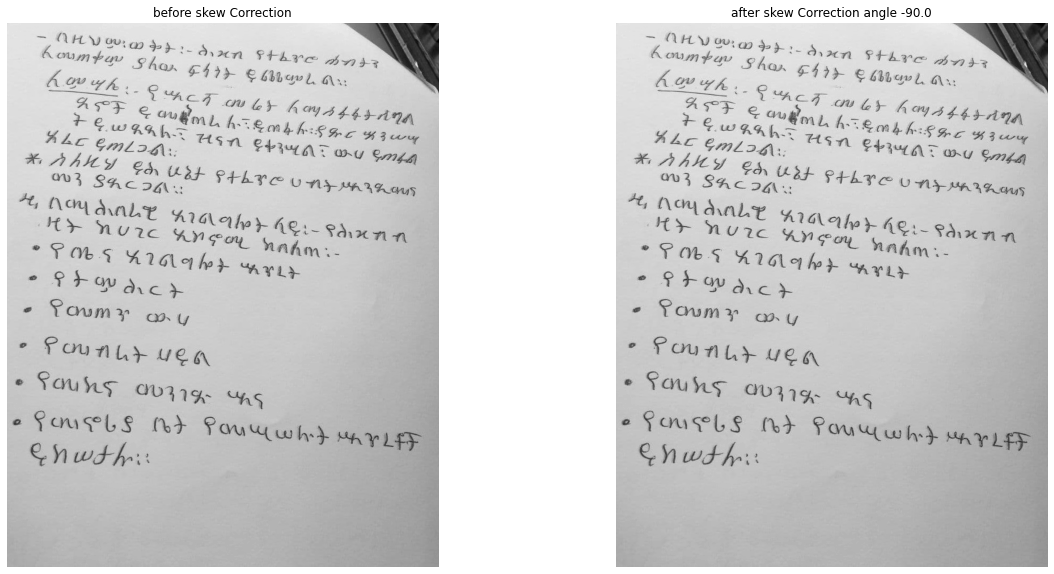

In [ ]:
#skew correction
def skewCorrection(image, angle):
  #
  if angle < -45:
    angle = -(90 + angle)
  # otherwise, just take the inverse of the angle to make
  # it positive
  else:
    angle = -angle
  # rotate the image to deskew it
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  de_sekwed_img = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  #
  return de_sekwed_img
if __name__ == "__main__":
  image = rgb2gray(imread("/content/drive/MyDrive/line-segmentation-handwritten-doc-master/1.jpg"))
  #check the image if it skewed
  inv = cv2.bitwise_not(img_as_ubyte(image))
  coords = np.column_stack(np.where(inv > 0))
  angle = cv2.minAreaRect(coords)[-1]
  # check the image if it skewed correct the angle
  if angle != 90:
    image1 = skewCorrection(image, angle) #img_as_float(skewCorrection(image, angle))
    # image1 = Image.fromarray(skewCorrection(image, angle))
    fig, ax = plt.subplots(figsize=(20,10), ncols=2)
    ax[0].axis("off")
    ax[1].axis("off")
  #   #
    ax[0].title.set_text("before skew Correction")
    ax[0].imshow(image, cmap="gray")
  #   #
    ax[1].title.set_text("after skew Correction angle {}".format(angle))
    ax[1].imshow(image1, cmap="gray")
  #   # 
  #   image = image1
  # print(np.max(image), np.min(image))
  from google.colab.patches import cv2_imshow
  from google.colab import files
  # cv2_imshow(image1)
  # cv2.imwrite("corrected.png", image1)
  plt.imshow(image1, cmap="gray")
  plt.savefig("corectedImg.png")
  files.download("corectedImg.png") 

peaks 
 [[0, 32.70893827585472], [1, 33.84788073472398], [2, 34.992621026309735], [3, 36.14169720245395], [4, 37.29365751077523], [5, 38.447068625139515], [6, 39.600522850203106], [7, 40.752644758030236], [8, 41.9020984582668], [9, 43.0475950612917], [10, 44.18789934146711], [11, 45.32183443299295], [12, 46.44828742030719], [13, 47.566214749641695], [14, 48.674645454112806], [15, 49.772685151834665], [16, 50.85951821195721], [17, 51.934409829546226], [18, 52.99670741890834], [19, 54.045840972585026], [20, 55.08132216345248], [21, 56.10274253955562], [22, 57.109771797878615], [23, 58.102155585465816], [24, 59.079711922050755], [25, 60.042327019661975], [26, 60.98995088708298], [27, 61.92259144436698], [28, 62.840308698010915], [29, 63.743208191367145], [30, 64.63143357689096], [31, 65.5051587559191], [32, 66.364580414611], [33, 67.20990967264433], [34, 68.04136422861112], [35, 68.85915990621072], [36, 69.66350279039318], [37, 70.45458189924422], [38, 71.2325617050075], [39, 71.997574205

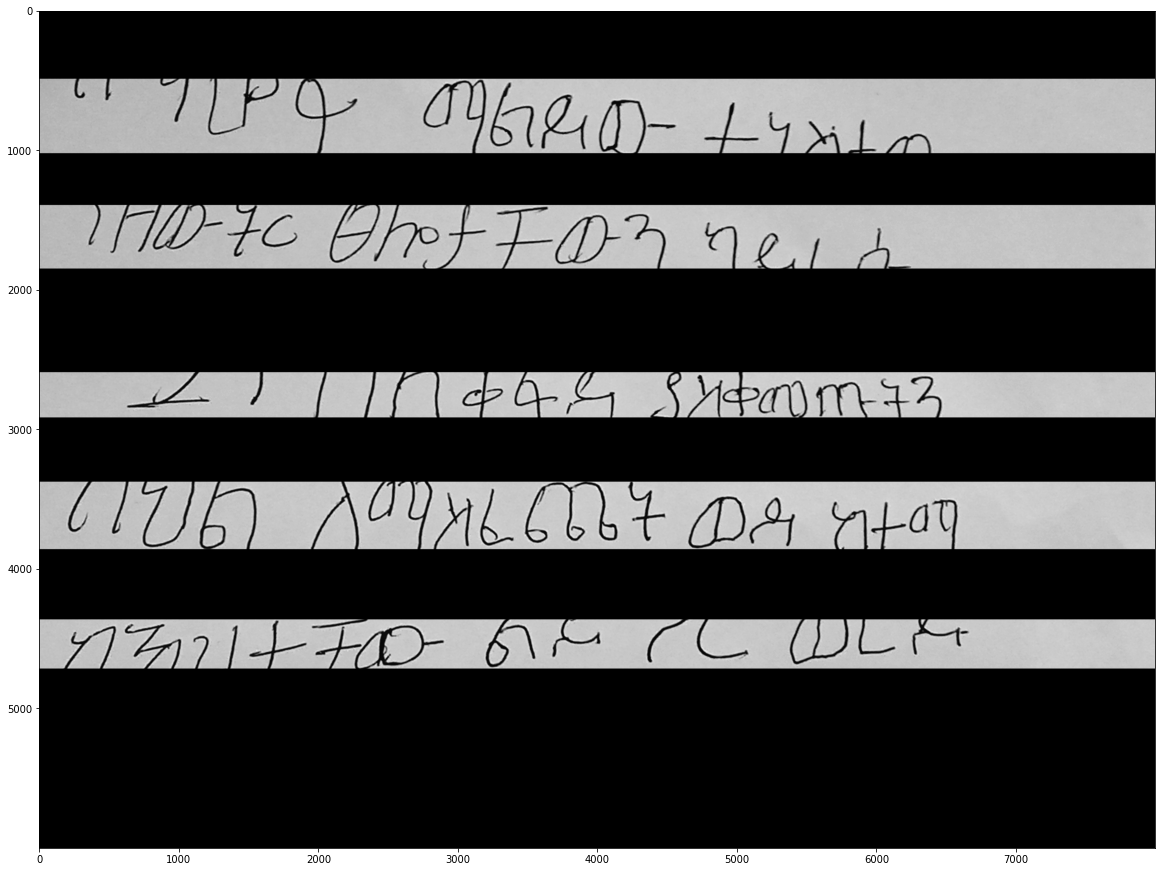

(6000, 8000)
(491, 8000)
(370, 8000)
(741, 8000)
(459, 8000)
(502, 8000)
(8130, 2)
[array([[ 245, 7999],
       [ 244, 7998],
       [ 244, 7997],
       ...,
       [ 245,    3],
       [ 245,    2],
       [ 245,    1]])]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(8106, 2)
[array([[ 245, 7999],
       [ 244, 7998],
       [ 244, 7997],
       ...,
       [ 245,    3],
       [ 245,    2],
       [ 245,    1]]), array([[1210, 7999],
       [1210, 7998],
       [1210, 7997],
       ...,
       [1210,    3],
       [1210,    2],
       [1210,    1]])]
(8227, 2)
[array([[ 245, 7999],
       [ 244, 7998],
       [ 244, 7997],
       ...,
       [ 245,    3],
       [ 245,    2],
       [ 245,    1]]), array([[1210, 7999],
       [1210, 7998],
       [1210, 7997],
       ...,
       [1210,    3],
       [1210,    2],
       [1210,    1]]), array([[2221, 7999],
       [2220, 7998],
       [2220, 7997],
       ...,
       [2221,    3],
       [2221,    2],
       [2221,    1]])]
(8026, 2)
[array([[ 245, 7999],
       [ 244, 7998],
       [ 244, 7997],
       ...,
       [ 245,    3],
       [ 245,    2],
       [ 245,    1]]), array([[1210, 7999],
       [1210, 7998],
       [1210, 7997],
       ...,
       [1210,    3],
       [1210,    2],
       [12

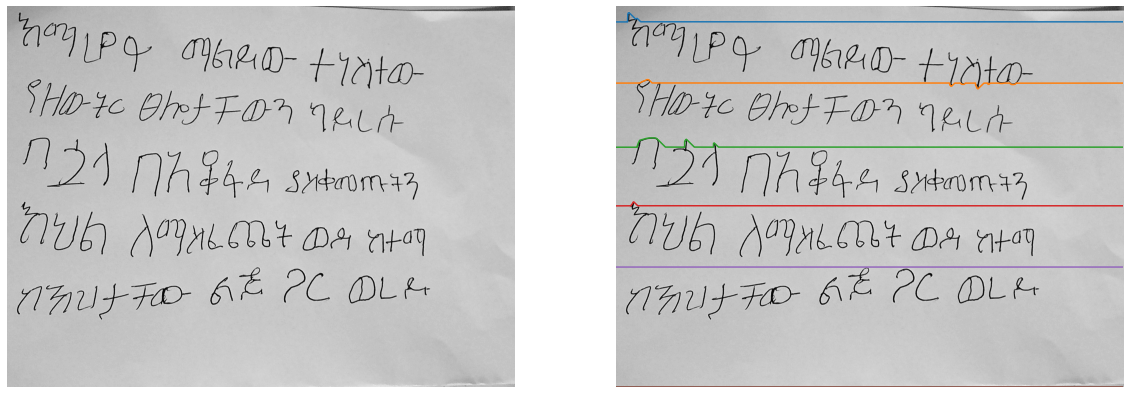

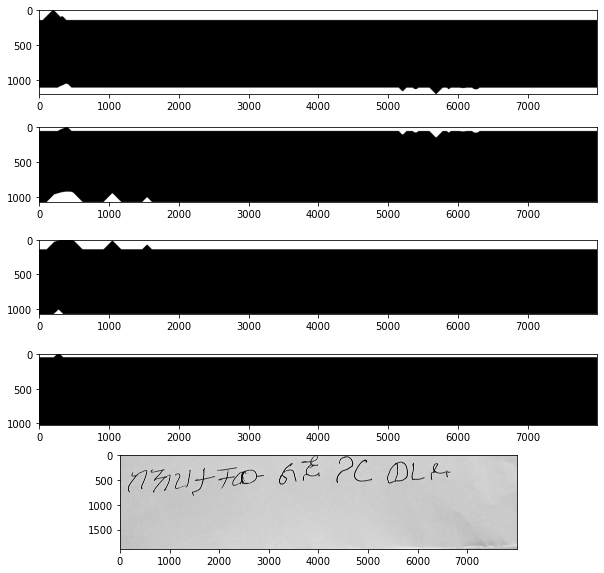

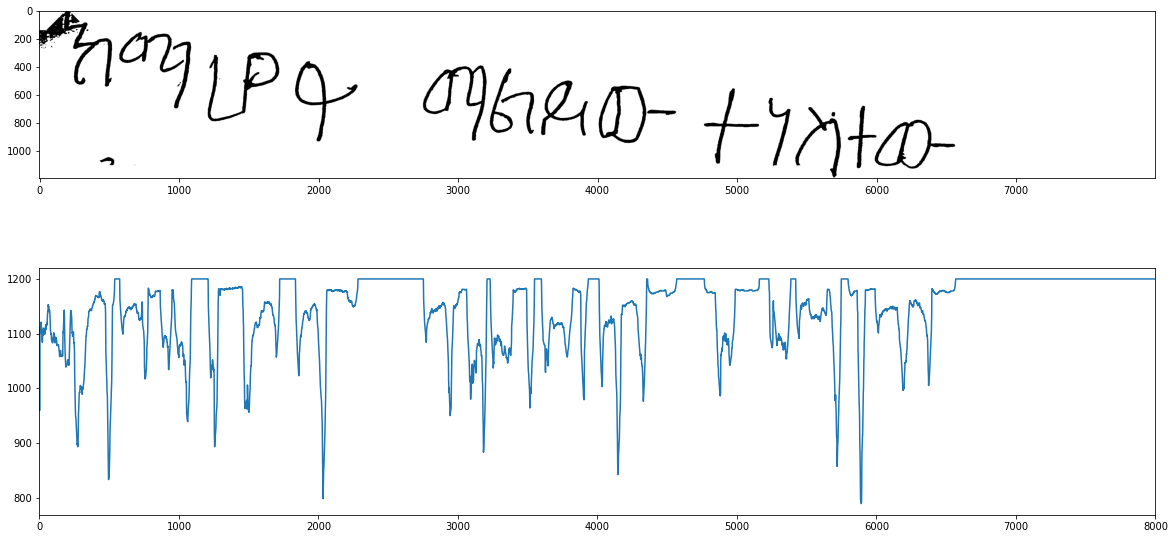

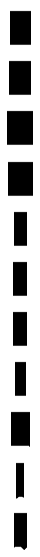

In [ ]:
if __name__ == "__main__":
  #reading the image in grayscale
  image = rgb2gray(imread("/content/drive/MyDrive/12.jpg"))
  #specifying the segmetation type as for line segmentation: line
  #                                   for word segmentation: word
  choice = "line"
   #specifying parameters
  # defining sigma for the low pass filter 
  sigma = 25
  #defining block_size, offset, for converting the grayscale image to bimodal
  block_size = 25
  offset=10
  #defining the divider to specify the window size while segmenting with projection
  divider= 1.35
  #creating object of the segment class
  test_Object = segment(image)
  #calling the segementation attribute of the segment class object
  list_of_characters = test_Object.segmentaion(choice, sigma, block_size, offset, divider)
  # print(len(list_of_characters))